***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* 8. Calibration 
    * Previous: [8.1 Jones Formalism of the Measurement Equation]()
    * Next: [8.3 1GC calibration: point source, derive bandpass gains]()

***

Import standard modules:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import section specific modules:

In [5]:
from scipy import optimize

## 8.2 Calibration as a Least Squares Problem <a id='cal:sec:cal_ls'></a> <!--\label{cal:sec:cal_ls}-->

### 8.2.1 Creating $uv$-Tracks: East-West Interferometer

It trivially follows from Sec. ?? that when we work with an east-west interferometer things simplify to a large degree. Firstly: $XYZ = [0~d~0]^T$, where $d$ is the baseline length.

Moreover, we have that:

\begin{eqnarray}
u &=& d\cos H\\
v &=& d\sin H \sin \delta,
\end{eqnarray} <a id='cal:eq:uv_cov'></a> <!--\label{cal:eq:uv_cov}-->

where $H$ is the hour angle of the field center and $\delta$ its declination. In this section we will be plotting the $uv$-coverage of a three element east-west interferometer.
The ENU layout of a simpe interferometer is given below. Note that $d$ is measured in wavelengths.

lam =  0.214285714286
d [wavelengths] =  [  466.66666667   933.33333333  1400.        ]


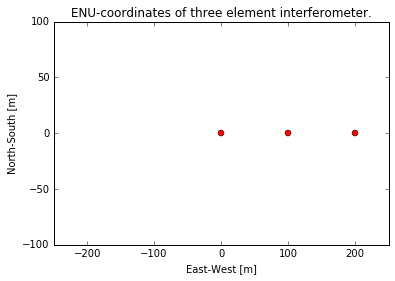

In [21]:
lam = 3e8/1.4e9 #observational wavelenth
print "lam = ",lam
d = np.array([100,200,300])/lam
print "d [wavelengths] = ",d
plt.plot(np.array([0,100,200]),np.array([0,0,0]),'ro')
plt.xlim([-250,250])
plt.ylim([-100,100])
plt.xlabel("East-West [m]")
plt.ylabel("North-South [m]")
plt.title("ENU-coordinates of three element interferometer.")
plt.show()

We first need to set the hour angle range of our observation and the declination of our field center.

In [18]:
H = np.linspace(-6,6,600)*(np.pi/12) #Hour angle in radians
delta = 60*(np.pi/180) #Declination in radians

Eq. [INREF](#cal:eq:uv_cov) <!--\ref{cal:eq:uv_cov}--> now enables us to create the $uv$-coverage of this simple three element interferometer.

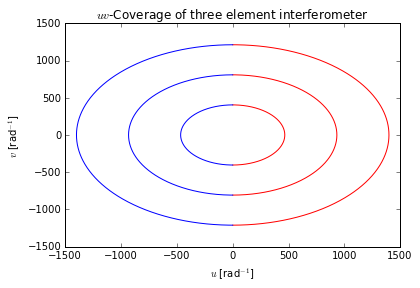

In [15]:
u = np.zeros((len(d),len(H)))
v = np.zeros((len(d),len(H)))
for k in xrange(len(d)):
    u[k,:] = d[k]*np.cos(H)
    v[k,:] = d[k]*np.sin(H)*np.sin(delta)
    plt.plot(u[k,:],v[k,:],"r")
    plt.plot(-u[k,:],-v[k,:],"b")
plt.xlabel("$u$ [rad$^{-1}$]")
plt.ylabel("$v$ [rad$^{-1}$]")
plt.title("$uv$-Coverage of three element interferometer")
plt.show()

We can also pack the $uv$-coverage into a 2D dimensional matrice. We denote the 
rows of this matrice with $p$ and the column with $q$. The $pq$-th entry denotes
the $uv$-track associated with baseline $pq$. The reason for packing the visibilities
into a 2D structure will become apparent later.

In [27]:
u_m = np.zeros((len(d),len(d),len(H)))
v_m = np.zeros((len(d),len(d),len(H)))

u_m[0,1,:] = u[0,:] #the first two entries denote p and q and the third index denotes time
u_m[1,2,:] = u[1,:]
u_m[0,2,:] = u[2,:]

v_m[0,1,:] = v[0,:]
v_m[1,2,:] = v[1,:]
v_m[0,2,:] = v[2,:]

### 8.2.2. Unpolarized Calibration

As explained in Sec. ?? the RIME assumes that our observed signal is polarized. For the sake
of simplicity we will now re-introduce the calibration problem by assuming that the observed signal is unpolarized. Unpolarized calibration is achieved by solving the following minimization problem:
\begin{equation}
\min_{\mathbf{G}} \left \| \mathbf{R} - \mathbf{G}\mathbf{M}\mathbf{G}^H \right \|,
\end{equation}
where
* $\mathbf{R}$ is the *observed visibility matrix*. Each entry, which we denote by $r_{pq}$, represents the visibility measured by the baseline formed by antennas $p$ and $q$.
* $\mathbf{M}$ is the *model visibility matrix*. The entry $m_{pq}$ of $\mathbf{M}$ denotes a non-measured or a model visibility which was created with the calibration sky model and a $uv$-point on the $uv$-track associated with baseline $pq$.
* $\mathbf{G} = \textrm{diag}(\mathbf{g})$ is the *antenna gain matrix*, where $\mathbf{g}=[g_1,g_2,\cdots,g_N]^T$ denotes the *antenna gain vector*. The operator $\textrm{diag}(\cdot)$ forms a diagonal matrix from a vector by putting the elements of the vector on the main diagonal. The vector $\mathbf{g}$ represents the instrumental response of the antennas, i.e. the complex antenna gains. These antenna gains are chosen in such a way that they minimize the difference between the observed and model visibilities. 
* $\mathbf{G}\mathbf{M}\mathbf{G}^H$ is the *predicted visibility matrix*. This matrix contains the model visibilities after the antenna gains have been applied to them. 

The superscript $(\cdot)^H$ denotes the Hermitian or conjugate transpose and $\left \| \cdot \right \|$ denotes the norm used. Most calibration algorithms use the Frobenius norm for matrices and the 2-norm or Euclidean norm for vectors, thus treating calibration as a least squares problem. 

### 8.2.3. Creating an Unpolarized Visibility Matrix (`create_vis_mat`)

In this section we present a function that allows us to create the observed visibility matrix $\mathbf{R}$ and 
the model visibility matrix $\mathbf{M}$. The function employs three seperate 
steps to produce a visibility matrice, namely:

* We first take the Fourier transform of the skymodel and then sample the result using the 
sampling function (i.e. $uv$-coverage). The skymodel can only consist of point sources. Mahtematically we may represent our skymodel as $I(l,m) = \sum_k A_k\delta(l-l_k,m-m_k)$, where $A_k$ denotes the flux of the $k$-th source and $(l_k,m_k)$ denotes the direction cosine position vector that is associated with the $k$-th source. We then have that
$V(u,v) = \mathcal{F}\{I(l,m)\} = A_k e^{-2\pi i l_k u + m_k v}$, where $\mathcal{F}\{\cdot\}$ denotes the Fourier transform of its operand. This result stems from the fact that the Fourier transform of a delta function is a complex exponential. If we now apply the sampling function we finally obtain $V_{pq}(u_{pq},v_{pq}) = A_k e^{-2\pi i l_k u_{pq} + m_k v_{pq}}$. We now use $V_{pq}$ to construct a 2D model visibility matrix. The skymodel is passed to the function via the variable `point_sources`. The sampling function is passed in via `u_m` and `v_m`. 
* We then corrupt the visibilities with the antenna gains that were passed into the function via `g`. We use `g` to construct $\mathbf{G}$. We corrupt our visibilites by multiplying by $\mathbf{G}$ on the left of the model visibility matrix and on the right by $\mathbf{G}^H$.
* The last step is to add some noise to our visibilities. The std of the noise is passed in via `sig`.

It should now be obvious how we can use the same function to produce both $\mathbf{M}$ and
$\mathbf{R}$. In the case of $\mathbf{M}$, we just do not corrupt our visibilities, nor
add any noise. Find the function `create_vis_mat` below.

In [32]:
'''Creates the observed visibilities
point_sources - skymodel of point sources - (amplitude, l, m)
u_m - the u coordinates of observation (packed in a 2D structure)
v_m - the v coordinates of observation (packed in a 2D structure)
g - the antenna gain error vector
sig - the noise
'''
def create_vis_mat(point_sources,u_m,v_m,g,sig):
    R = np.zeros(u.shape)
    G = np.diag(g)
    #Step 1: Create Model Visibility Matrix
    for k in xrange(len(point_sources)): #for each point source
        l_0 = point_sources[k,1]
        m_0 = point_sources[k,2]
        R = R + point_sources[k,0]*np.exp(-2*np.pi*1j*(u_m*l_0+v_m*m_0))
    
    for t in xrange(R.shape[2]): #for each time-step
        
        #Step 2: Corrupting the Visibilities 
        R[:,:,t] = np.dot(G,R[:,:,t])
        R[:,:,t] = np.dot(R[:,:,t],G.conj()) 
        
        #Step 3: Adding Noise
        R[:,:,t] = R[:,:,t] + sig*np.random.randn(u_m.shape[0],u_m.shape[1]) + sig*np.random.randn(u_m.shape[0],u_m.shape[1])*1j
    
    return R

We now use `create_vis_mat` to create an example $\mathbf{M}$ and $\mathbf{R}$. Note that
there are two sources in our skymodel.

In [56]:
point_sources = np.array([(1,0,0),(0.5,(1*np.pi)/180,(0*np.pi)/180)]) #l and m are measures in radians
g = np.array([1.2+1.3j,1.1-1.5j,-1.3+0.7j])
sig = 0.1
R = create_vis_mat(point_sources,u_m,v_m,g,sig) #we corrupt our data and we add noise
M = create_vis_mat(point_sources,u_m,v_m,np.array([1,1,1]),0) #no corruption and no noise 

We now plot the baseline entries of $\mathbf{M}$ and $\mathbf{R}$.

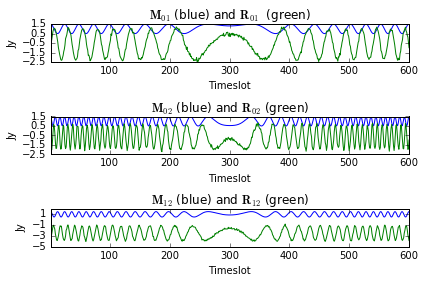

In [96]:
fig = plt.figure()

timeslots = np.cumsum(np.ones((len(M[0,1,:]),)))

#Plotting Baseline 01
ax = plt.subplot("311")
ax.set_title("$\mathbf{M}_{01}$ (blue) and $\mathbf{R}_{01}$  (green)")
ax.plot(timeslots,M[0,1,:])
ax.plot(timeslots,R[0,1,:])
ax.set_xlabel("Timeslot")
ax.set_ylabel("Jy")
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 02
ax = plt.subplot("312")
ax.set_title("$\mathbf{M}_{02}$ (blue) and $\mathbf{R}_{02}$ (green)")
ax.plot(timeslots,M[0,2,:])
ax.plot(timeslots,R[0,2,:])
ax.set_xlabel("Timeslot")
ax.set_ylabel("Jy")
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 12
ax = plt.subplot("313")
ax.set_title("$\mathbf{M}_{12}$ (blue) and $\mathbf{R}_{12}$ (green)")
ax.plot(timeslots,M[1,2,:])
ax.plot(timeslots,R[1,2,:])
ax.set_xlabel("Timeslot")
ax.set_ylabel("Jy")
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

plt.tight_layout()

plt.show()

### 8.2.4 Levenberg-Marquardt (`create_G_LM`)

We are now ready to use least squares to calibrate $\mathbf{R}$.

We first present a brief review of least squares minimization. Suppose it is desired to fit a set of data $\left\{ \mathbf{m}_{i},\mathbf{r}_{i}\right\}$ to a known model $\mathbf{f}\left( \mathbf{m},\mathbf{g}^*\right)$, where $\mathbf{g}^*$ denotes a vector of unknown variables. These unknown variables parameterize the known model. A standard method for determining which parameter vector $\mathbf{g}^*$ best fits the data is to minimize the sum of squared residuals. This technique is referred to as least squares minimization. The residual vector is denoted by $\mathbf{e}(\mathbf{m},\mathbf{r},\mathbf{g}^*) = \mathbf{r} - \mathbf{f}\left( \mathbf{m},\mathbf{g}^*\right)$. The objective function (the function we wish to minimize) associated with least squares is therefore: $\sum_i \mathbf{e}_i^2$. The function `optimize.leastsq` is a `scipy` least squares solver that employs the Levenber-Marquardt algorithm in the background. The Levenber-Marquardt algorithm is discussed in more detail in Sec. ??. To use `optimize.leastsq` one needs a function, `err_func`, that calculates the residual vector $\mathbf{e}$ and an initual guess of the parameter vector $\mathbf{g}^*$. One also requires the observed $\mathbf{r}$ and model input values $\mathbf{m}$.

For calibration the above variables become:

* $\mathbf{r} = [\textrm{vec}(\mathcal{R}\{\mathbf{R}\}),\textrm{vec}(\mathcal{I}\{\mathbf{R}\})]$
* $\mathbf{m} = [\textrm{vec}(\mathcal{R}\{\mathbf{M}\}),\textrm{vec}(\mathcal{I}\{\mathbf{M}\})]$
* $\mathbf{g}^* = [\mathcal{R}\{\mathbf{g}\},\mathcal{I}\{\mathbf{g}\}]$
* $\mathbf{f}\left( \mathbf{m},\mathbf{g}^*\right) = [\textrm{vec}(\mathcal{R}\{\mathbf{G}\mathbf{M}\mathbf{G}^H\}),\textrm{vec}(\mathcal{I}\{\mathbf{G}\mathbf{M}\mathbf{G}^H\})]$, where
$\mathbf{M} = \textrm{vec}^{-1}(\overline{\mathbf{m}})+i\textrm{vec}^{-1}(\underline{\mathbf{m}})$ and $\mathbf{G} = \textrm{diag}(\overline{\mathbf{g}}^*)+i\textrm{diag}(\underline{\mathbf{g}}^*)$. 

In the above bullets $\textrm{vec}(\cdot)$, $\textrm{vec}^{-1}(\cdot)$, $\overline{(\cdot)}$,
and $\underline{(\cdot)}$ respectively denote vectorization, matrization, the upper halve of
a vector and the lower halve of a vector. Moreover, $\mathcal{R}\{\cdot\}$ and $\mathcal{I}\{\cdot\}$ respectively denote the real and imaginary part of their respective operands.

The first thing we need to define in order to perform calibration by using `optimize.leastsq` is the function `err_func`, which we do below.

In [87]:
'''Unpolarized direction independent calibration entails finding the G that minimizes ||R-GMG^H||. 
This function evaluates R-GMG^H.
g is a vector containing the real and imaginary components of the antenna gains.
r is a vector containing a vecotrized R (observed visibilities), real and imaginary.
m is a vector containing a vecotrized M (predicted), real and imaginary.
e is a vector containing the residuals.
''' 
def err_func(g,r,m):
    Nm = len(r)/2
    N = len(g)/2
    G = np.diag(g[0:N]+1j*g[N:])
    R = np.reshape(r[0:Nm],(N,N))+np.reshape(r[Nm:],(N,N))*1j #matrization
    M = np.reshape(m[0:Nm],(N,N))+np.reshape(m[Nm:],(N,N))*1j
    T = np.dot(G,M)
    T = np.dot(T,G.conj())
    E = R - T
    e_r = np.ravel(E.real) #vectorization
    e_i = np.ravel(E.imag)
    e = np.hstack([e_r,e_i])
    return e

We are now able to define a wrapper function `create_G_LM` that in turn calls `optimize.leastsq`.
The wrapper function translates the calibration problem into a format that `optimize.leastsq`
can interpret. The input of `create_G_LM` is $\mathbf{R}$ and $\mathbf{M}$, while the output is $\mathbf{g}$ and $\boldsymbol{\mathcal{G}}=\mathbf{g}\mathbf{g}^H$. Find the wrapper below. 

In [88]:
'''This function finds argmin G ||R-GMG^H|| using Levenberg-Marquardt. It uses the optimize.leastsq scipy to perform
the actual minimization.
R is your observed visibilities matrx.
M is your predicted visibilities.
g the antenna gains.
G = gg^H.''' 
def create_G_LM(R,M):
    N = R.shape[0] #number of antennas
    temp =np.ones((R.shape[0],R.shape[1]) ,dtype=complex)
    G = np.zeros(R.shape,dtype=complex)
    g = np.zeros((R.shape[0],R.shape[2]),dtype=complex)
   
    for t in xrange(R.shape[2]): #perform calibration per time-slot
        g_0 = np.ones((2*N,)) # first antenna gain guess 
        g_0[N:] = 0
        r_r = np.ravel(R[:,:,t].real) #vectorization of observed + seperating real and imag
        r_i = np.ravel(R[:,:,t].imag)
        r = np.hstack([r_r,r_i])
        m_r = np.ravel(M[:,:,t].real) #vectorization of model + seperating real and imag
        m_i = np.ravel(M[:,:,t].imag)
        m = np.hstack([m_r,m_i])
        g_lstsqr_temp = optimize.leastsq(err_func, g_0, args=(r, m))
        g_lstsqr = g_lstsqr_temp[0]          
           
        G_m = np.dot(np.diag(g_lstsqr[0:N]+1j*g_lstsqr[N:]),temp)
        G_m = np.dot(G_m,np.diag((g_lstsqr[0:N]+1j*g_lstsqr[N:]).conj()))           

        g[:,t] = g_lstsqr[0:N]+1j*g_lstsqr[N:] #creating antenna gain vector       
        G[:,:,t] = G_m
         
    return g,G

We may now calibrate $\mathbf{R}$ by using `create_G_LM`. 

In [91]:
glm,Glm = create_G_LM(R,M)

The above function works, by vectorizing the real and imaginary part of $\mathbf{R}$ and
storing the result in $\mathbf{r}$. The vector $\mathbf{m}$ is generated in a similar manner.
The error vector $\mathbf{e}$ is calculated by `err_func`. We initialize $\mathbf{g}^*$ with
$\mathbf{g}^*_0=[\mathbf{1},\mathbf{0}]$. We can then call 

`optimize.leastsq(self.err_func, g_0, args=(r, m))`.

We can now calculate $\mathbf{g} = \overline{\mathbf{g}}^*+i\underline{\mathbf{g}}^*$ and
$\boldsymbol{\mathcal{G}}=\mathbf{g}\mathbf{g}^H$. This is repeated for each observational time-slot.

### 8.2.5 Corrected Visibilites 

Before imaging, we have to correct our observed visibilities by removing the effect that the antenna gains had on the observed visibilities. This can be accomplished by using
\begin{equation}
 \mathbf{R}^\mathrm{(c)} = \mathbf{G}^{-1}\mathbf{R}\mathbf{G}^{-H} = \boldsymbol{\mathcal{G}}^{\odot-1}\odot\mathbf{R},
\end{equation}
where

* $\mathbf{R}^\mathrm{(c)}$ is the *corrected visibility matrix*.
* $\boldsymbol{\mathcal{G}}^{\odot-1}$ denotes the *visibility calibration matrix*, which is computed by taking the Hadamard inverse of $\boldsymbol{\mathcal{G}}$.

The superscript $(\cdot)^{-1}$ denotes matrix inversion, while $(\cdot)^{-H}$ denotes the inverse of the Hermitian transpose. The operator $\odot$ denotes the Hadamard product. 
We calculate the corrected visibilities below.

In [94]:
R_c = Glm**(-1)*R

We plot the corrected visibilities below. Note that the model and corrected visibilities align well, implying that calibration was successfull.

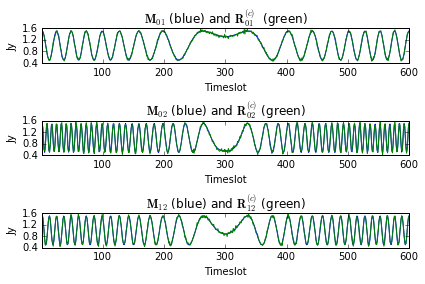

In [98]:
fig = plt.figure()

timeslots = np.cumsum(np.ones((len(M[0,1,:]),)))

#Plotting Baseline 01
ax = plt.subplot("311")
ax.set_title("$\mathbf{M}_{01}$ (blue) and $\mathbf{R}_{01}^{(c)}$  (green)")
ax.plot(timeslots,M[0,1,:])
ax.plot(timeslots,R_c[0,1,:])
ax.set_xlabel("Timeslot")
ax.set_ylabel("Jy")
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 02
ax = plt.subplot("312")
ax.set_title("$\mathbf{M}_{02}$ (blue) and $\mathbf{R}_{02}^{(c)}$ (green)")
ax.plot(timeslots,M[0,2,:])
ax.plot(timeslots,R_c[0,2,:])
ax.set_xlabel("Timeslot")
ax.set_ylabel("Jy")
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 12
ax = plt.subplot("313")
ax.set_title("$\mathbf{M}_{12}$ (blue) and $\mathbf{R}_{12}^{(c)}$ (green)")
ax.plot(timeslots,M[1,2,:])
ax.plot(timeslots,R_c[1,2,:])
ax.set_xlabel("Timeslot")
ax.set_ylabel("Jy")
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

plt.tight_layout()

plt.show()

***

Next: [8.3 1GC calibration: point source, derive bandpass gains]()